This repository contains an implementation of the algorithm presented in
*Black-box density function estimation using recursive partitioning*
[arXiv](https://arxiv.org/abs/2010.13632), referred to as DEFER (DEnsity Function Estimation using Recursive partitioning). The paper was presented at the International Conference on Machine Learning (ICML) 2021.

DEFER allows efficient Bayesian inference on general problems involving up to about ten random variables or dimensions,
without the need to specify anything else than
 - the unnormalised density function (which can be black-box),
 - domain bounds (enclosing the typical set, although allowed to be doing so with very large margins),
 - a density function evaluation budget.

The code comes with a high-level interface intended for ease-of-use.

Below we will show:
- How the DEFER algorithm can be used to approximate arbitrary distributions (of moderate dimension),
such as posterior distributions which are allowed to be e.g. multimodal, discontinuous, exhibit complicated correlations, and have zero density regions.
- Some available operations the approximation provides, including:
    - fast, constant time sampling,
    - computation of normalisation constant,
    - analytical expectations of functions with respect to the approximation,
    - conditionals to be derived quickly, and
    - approximate marginalisation of a subset of variables or dimensions.

In [1]:
import corner
import matplotlib.pylab as plt
from defer.helpers import *
from defer.variables import Variable
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# Configure plot defaults
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#666666'
%config InlineBackend.figure_format = 'png'

### Density function example
The DEFER algorithm constructs a distribution approximation given a provided (arbitrary) unnormalised density function $f$ which can be point-wise evaluated. 

In this example we provide the algorithm with such a function, namely where the density value at a given location depends on the distance to the closest point of a shape embedded in the same space. The particular shape used is a spiral embedded in three dimensions. The distance (as a function of $x$) is used as the energy function of a Gibbs distribution.

Note that the DEFER algorithm does not need to know what the function $f$ is or represents; it will simply query it with inputs and construct an approximation which allows operations that typically is not available using the original function $f$ (except for trivial $f$ and corresponding distributions).

In [2]:
def spiral(t):
    w = 6 * np.pi
    v = 0.9
    c = 1
    return np.array([
        t,
        (v * t + c) * np.cos(w * t),
        (v * t + c) * np.sin(w * t),
    ]).transpose()

# Domain bounds
curve_lower_x = -1
curve_upper_x = 1
other_dims_lower = [-2, -2]
other_dims_upper = [2, 2]
lower = [curve_lower_x] + other_dims_lower
upper = [curve_upper_x] + other_dims_upper

def find_shortest_distance(
  x, curve, lower_x=curve_lower_x, upper_x=curve_upper_x):
  trial_input_points = np.linspace(lower_x, upper_x, num=5000)
  curve_points = curve(trial_input_points)
  distances = np.linalg.norm(np.abs(curve_points - x), axis=1)
  index = int(np.argmin(distances))
  shortest_distance = distances[index]
  return shortest_distance

# Unnormalised density function. This can be any continuous-input function returning a density value.
def f(x):
  distance_to_closest_point_on_curve = find_shortest_distance(x, curve=spiral)
  energy = distance_to_closest_point_on_curve
  return np.exp(-30 * energy)

#### Variables
Declare the random variables, corresponding to the parameters of the density function $f$.
In this example, we only have a single parameter $x$, and thus only one random variable.

The Variables object produces the density function domain (variables.domain) - or sample space. It will also keep track of mappings between variables (or slices of them using []) to the corresponding dimensions.

Note that the variables do not have any state - they simply act as semantic collections of dimensions with defined boundaries. Having the variables kept together as a collection in the Variables object will be particularly useful for keeping track of what remains when deriving conditionals or marginals (more on that later).

In [3]:
x = Variable(
  lower=lower,
  upper=upper,
  name="x"
)
variables = Variables([x])
joint_distribution = None
x1 = None
x2 = None
x3 = None
x4 = None
x5 = None

#### Construct approximation
Here we use a high-level wrapper around the DEFER algorithm which given the $f$-function definition and the variables (setting the domain boundaries), returns a distribution approximation.

The budget of the algorithm, in terms of number of evaluations of $f$, is set using 'num_fn_calls'. Note that this number may differ slightly from the calls actually used (by a few evaluations). This is because the construction of each partition (see paper) requires more than one density evaluations, and thus the total may not add up exactly to the provided number.

Note that 'is_log_fn' also needs to be specified. 'is_log_fn' should be set to True if the $f$ function returns the logarithm of the density value rather than the density value.

In [4]:
approx_posterior = construct(
  fn=joint_distribution,
  variables=Variables([x1, x2, x3, x4, x5]),
  is_log_fn=True,
  num_fn_calls=10000,
  callback=lambda i, current_approx: print(
    "#Iterations: %s. #Evaluations: %s. Log Z: %.2f" %
    (
        i,
        current_approx.num_partitions,
        np.log(current_approx.z)
    )),
  callback_freq_fn_calls=100,
)

evidence = approx_posterior.z
differential_entropy = approx_posterior.expectation(
    lambda f, x, z: -np.log(f / z))
sampler = approx_posterior.sampler()
posterior_samples = sampler(num_samples=1000000)
approx_conditional_posterior = approx_posterior.conditional({
  x1: np.array([0.5, 0.5])
})
conditional_sampler = approx_conditional_posterior.sampler()
...

#Evals: 7. Log Z: -4.71
#Evals: 3015. Log Z: -1.58
#Evals: 6019. Log Z: -1.48
#Evals: 9025. Log Z: -1.46
#Evals: 12027. Log Z: -1.41
#Evals: 15027. Log Z: -1.41
#Evals: 18039. Log Z: -1.41
#Evals: 21043. Log Z: -1.41
#Evals: 24063. Log Z: -1.40
#Evals: 27063. Log Z: -1.39
#Evals: 30001. Log Z: -1.39


Analytical expectation of functions with respect to the distribution approximation.
Due to the piece-wise constant approximation being used, this simply corresponds to a weighted summation. The 'expectation' method is for convenience for computing expectations of functions provided the function, taking the integrand ($f$) value, the corresponding parameters (concatenated to a vector), and the normalisation constant $z$, as parameters. In the below example the differential entropy is computed this way.

In [7]:
differential_entropy = approx_joint.expectation(lambda f, x, z: -np.log(f / z))

A few, very common such expectations are provided as methods (such as mean and variance), which are internally using the 'expectation' method.

In [8]:
mean = approx_joint.mean()
var = approx_joint.var()

The (estimated) mode is provided by the 'mode' method. This is simply the centroid of the partition of the approximation which has the highest associated $f$ value.

In [ ]:
mode = approx_joint.mode()

The approximation of the density function can be queried just as the original function $f$ by calling with the same parameter(s). A normalised version (the probability density) is provided using the 'prob' method.

In [9]:
x_test = np.array([0.5, 0.5, 0.5])
f_test = approx_joint(x_test)
p_test = approx_joint.prob(x_test)

Often what one is interested in is posterior samples. 
To obtain samples from the distribution approximation, we first construct a sampler function using the 'sampler' method. Internally it performs the pre-processing required to be able to sample very quickly.

In [10]:
sampler = approx_joint.sampler()

The sampler function allows sampling from the distribution in constant time per sample.
Below we draw one million samples. 
Returned is a list of numpy arrays - one array of samples per variable. 
In our example, however, we only have the $x$ variable (with three dimensions).

In [24]:
x_samples, = sampler(num_samples=1000000)
x_samples.shape

(1000000, 3)

The DensityFunctionApproximation can easily be saved or loaded using the 'save' and 'load' methods. Internally the tree-structure of partitions (only) are saved/loaded, instead of the whole Python object.

In [12]:
approx_joint.save("/tmp/approx_joint.pickle")
approx_joint.load("/tmp/approx_joint.pickle")

We will now plot the samples in a corner plot in order to visualize the distribution.

Plotting..


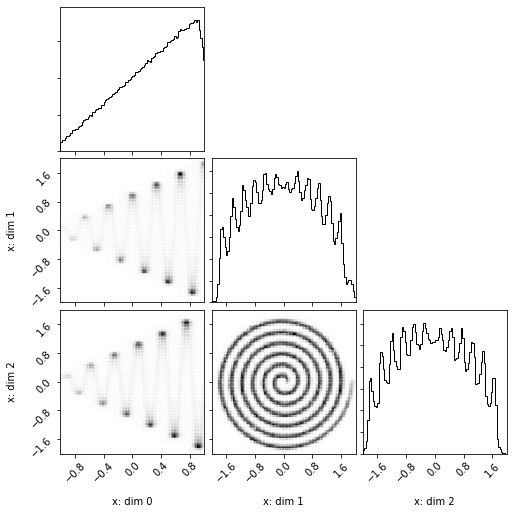

In [13]:
def plot(density: DensityFunctionApproximation, samples=None):
  if samples is None:
      print("Preparing sampler..")
      sampler = density.sampler()
      print("Sampling..")
      samples_per_variable = sampler(num_samples=10 ** 6)
      samples = np.concatenate(samples_per_variable, axis=-1)
  print("Plotting..")
  figure = corner.corner(
    samples,
    range=density.variables.bounds,
    labels=[
      "%s: dim %s" % (var.name, index)
      for var in density.variables.variable_slices
      for index in var.indices
    ],
    plot_contours=False,
    no_fill_contours=True,
    bins=100,
    plot_datapoints=False,
  )
  plt.show()

plot(approx_joint, samples=x_samples)

#### Conditionals
We can easily derive a conditional using the 'conditional' method,
yielding a new approximation of the same type.
In this example we condition the last dimension of the $x$ variable to 0.5.

In [14]:
approx_conditional: DensityFunctionApproximation = approx_joint.conditional({
  x[-1]: np.array([0.5])
})

Let us plot samples from the derived conditional in a corner plot to visualize it.

Preparing sampler..
Sampling..
Plotting..


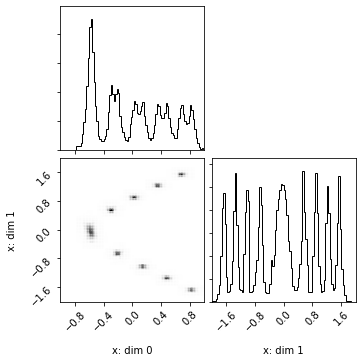

In [15]:
plot(approx_conditional)

The conditional of the approximation, being of the same type, provides the same methods and properties. 
Including its normalisation constant, mode, and methods for returning density values and computing expectations.

In [16]:
z = approx_conditional.z
approx_conditional.mode()
approx_conditional.expectation(lambda f, x, z: -np.log(f / z))
approx_conditional.mean()
approx_conditional.var()
approx_conditional.prob(np.array([0.5, 0.5]))

7.837536348532179338e-08

#### Marginalisation
We may also marginalise variables (or dimensions of variables) using the 'construct_marginal' helper function. Internally it treats marginalisation as just another problem for the DEFER algorithm: now where each $f$ evaluation requires (approximate) integration over some variables - which using this helper function is performed using DEFER as well, i.e. in an inner-loop. 

Returned is a DensityFunctionApproximation similar to in the previously discussed cases. 

Note that in this example the provided $f$ is the constructed approximation of $f$, rather than $f$ itself. This can allow a significant speed-up if $f$ takes relatively much time to evaluate (more than several milliseconds). Alternatively $f$ can be passed in instead.

In the below example the first dimension of the $x$ variable is marginalised, returning a distribution now only two dimensions rather than three.

In [17]:
approx_marginal: DensityFunctionApproximation = construct_marginal(
  fn=approx_joint,
  variables=variables,
  marginalize_variable_slices=[x[0]],
  is_log_fn=False,
  num_outer_fn_calls=5000,
  num_inner_fn_calls=15,
  callback=lambda i, density:
  print("#Evals: %s. Log Z: %.2f" %
        (density.num_partitions, np.log(density.z))),
  callback_freq_fn_calls=500,
)

#Evals: 5. Log Z: -1.16
#Evals: 509. Log Z: -1.48
#Evals: 1009. Log Z: -1.48
#Evals: 1509. Log Z: -1.46
#Evals: 2011. Log Z: -1.45
#Evals: 2515. Log Z: -1.44
#Evals: 3019. Log Z: -1.44
#Evals: 3523. Log Z: -1.44
#Evals: 4027. Log Z: -1.43
#Evals: 4531. Log Z: -1.43
#Evals: 5007. Log Z: -1.43


Preparing sampler..
Sampling..
Plotting..


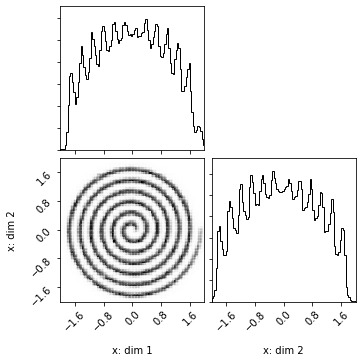

In [18]:
plot(approx_marginal)

In [19]:
approx_marginal.z
approx_marginal.mode()
approx_marginal.expectation(lambda f, x, z: -np.log(f / z))
approx_marginal.mean()
approx_marginal.var()
approx_marginal.prob(np.array([0.5, 0.5]))

0.060272058916242459574

#### Combining operations arbitrarily.
As the marginal approximation provides the same operations, 
we can of course, for example, derive a conditional of the marginal similar to before - or use any of the other operations, in any order.

In [20]:
approx_conditional_of_marginal = approx_marginal.conditional({
  x[-1]: np.array([0.5])
})

Preparing sampler..
Sampling..
Plotting..


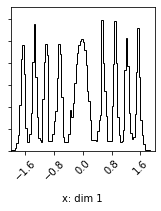

In [21]:
plot(approx_conditional_of_marginal)

In [22]:
approx_conditional_of_marginal.z
approx_conditional_of_marginal.mode()
approx_conditional_of_marginal.expectation(lambda f, x, z: -np.log(f / z))
approx_conditional_of_marginal.mean()
approx_conditional_of_marginal.var()
approx_conditional_of_marginal.prob(np.array([0.5]))

0.18142085889723261718